<a href="https://colab.research.google.com/github/bmjaron/phase_4_project/blob/main/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Business Understanding

# II. Data Understanding

## A. Data Collection and Description

We'll begin by importing necessary libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import nltk
from nltk.collocations import *
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

We'll now load the data and preview.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/bmjaron/phase_4_project/main/data.csv')

df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
df.shape

(8721, 3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8720 non-null   object
 1   emotion_in_tweet_is_directed_at                     3169 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


In order to make the columns easier to work with, we're going to change the column names.

In [5]:
df = df.rename(columns={'tweet_text': 'text', 'emotion_in_tweet_is_directed_at': 'directed_at', 'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'})

We'll look at the different emotions shown in tweets.

In [6]:
df['emotion'].value_counts()

No emotion toward brand or product    5156
Positive emotion                      2869
Negative emotion                       545
I can't tell                           151
Name: emotion, dtype: int64

We can tell that we have data for 8,721 tweets that contain the text of the tweet, the brand or product that each given tweet is directed at, and whether or not the emotion expressed by the tweet is either positive or negative.

We also see that we have some instances of null values. In particular, there is one tweet that is missing the text. But what is more noteworthy is that we only have a little over 1/3 of the product/brand target of the tweet.  

## B. Exploratory Data Analysis

### **Are tweets generally positive or negative?**

We saw earlier that the emotions of our tweets can be broken down into 4 categories: 1) no emotion, 2) positive, 3) negative, 4) unable to determine emotion. Below, we'll visualize the break down.

<BarContainer object of 4 artists>

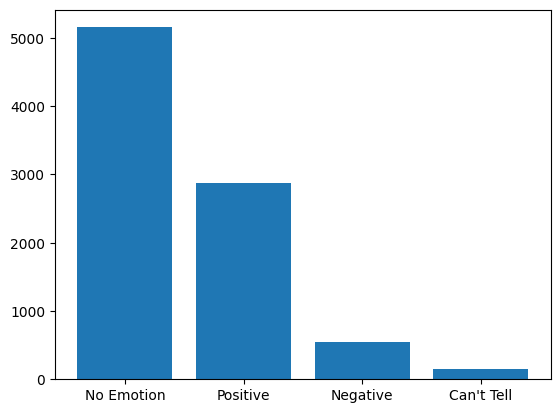

In [7]:
plt.bar(x=['No Emotion', 'Positive', 'Negative', "Can't Tell"],
        height=[df['emotion'].value_counts()[n] for n in range(4)])


### **What is the emotion of tweet based on products/brands?**




In [8]:
df['directed_at'].value_counts()

iPad                               910
Apple                              640
iPad or iPhone App                 451
Google                             412
iPhone                             288
Other Google product or service    282
Android App                         78
Android                             74
Other Apple product or service      34
Name: directed_at, dtype: int64

In [9]:
map_dict = {'Apple': ['iPad', 'Apple', 'iPad or iPhone App', 'iPhone', 'Other Apple product or service'],
            'Google': ['Google', 'Other Google product or service'],
            'Android': ['Android App', 'Android']}

df_2 = df.copy()
df_2 = df_2.dropna(axis=0)

df_2['directed_at'] = df_2['directed_at'].map(lambda x: 'Apple' if x in map_dict['Apple'] else (
                                                        'Google' if x in map_dict['Google'] else
                                                        'Android'))

df_2['directed_at'].value_counts()

Apple      2323
Google      694
Android     152
Name: directed_at, dtype: int64

In [10]:
#apple = df_2[df_2['directed_at'] == 'Apple']
#google = df_2[df_2['directed_at'] == 'Google']
#android = df_2[df_2['directed_at'] == 'Android']

#fig, axes = plt.subplots(1, 3, figsize=(16, 4))

#for n, b in enumerate([apple, google, android]):
 # axes[n].bar(x=['No Emotion', 'Positive', 'Negative', "Can't Tell"],
  #            height=[b['emotion'].value_counts()[x] for x in range(4)])

# III. Data Preparation

Clean and tokenize.

In [11]:
#Preview text of tweets

for tweet in df['text'][:10]:
  print(tweet)

.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.
@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW
@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.
@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw
@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)
@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd
nan
#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan
Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB
Counting down the days 

In [12]:
temp_string = df['text'][8]
temp_string = temp_string.lower()
temp_string = re.sub('https?://\S+', '', temp_string)
temp_string = re.sub('[^\w\s\d]', '', temp_string)

temp_string

'beautifully smart and simple idea rt madebymany thenextweb wrote about our hollergram ipad app for sxsw '

In [13]:
import string

def clean_tweets(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df_practice = df.copy()
df_practice.dropna(subset=['text'], inplace=True)
df_practice['text'] = df_practice['text'].map(lambda x: clean_tweets(x))

Let's preview some cleaned tweets.

In [14]:
for tweet in df_practice['text'][10:20]:
  print(tweet)

find amp start impromptu parties at sxsw with hurricaneparty  i cant wait til the android app comes out
foursquare ups the game just in time for sxsw   still prefer gowalla by far best looking android app to date
gotta love this sxsw google calendar featuring top parties show cases to check out  rt hamsandwich via ischafer gt
great sxsw ipad app from madebymany 
haha awesomely rad ipad app by madebymany  hollergram sxsw
holler gram for ipad on the itunes app store    via marcisken sxsw
i just noticed dst is coming this weekend how many iphone users will be an hour late at sxsw come sunday morning sxsw iphone
just added my sxsw flights to planely matching people on planesairports also downloaded the klm iphone app nicely done
must have sxsw app rt malbonster lovely review from forbes for our sxsw ipad app holler gram  
need to buy an  while im in austin at sxsw not sure if ill need to q up at an austin apple store


Tokenization.

In [15]:
df_practice['text'] = df_practice['text'].map(lambda x: nltk.word_tokenize(x))

In [16]:
df_practice.head()

,text,directed_at,emotion
0,"[i, have, a, iphone, after, hrs, tweeting, at,...",iPhone,Negative emotion
1,"[jessedee, know, about, fludapp, awesome, ipad...",iPad or iPhone App,Positive emotion
2,"[swonderlin, can, not, wait, for, ipad, also, ...",iPad,Positive emotion
3,"[sxsw, i, hope, this, years, festival, isnt, a...",iPad or iPhone App,Negative emotion
4,"[sxtxstate, great, stuff, on, fri, sxsw, maris...",Google,Positive emotion


Removing stopwords.

In [17]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

df_practice['text'] = df_practice['text'].map(lambda x: [word for word in x if word not in stop_words])

df_practice.head()


,text,directed_at,emotion
0,"[iphone, hrs, tweeting, riseaustin, dead, need...",iPhone,Negative emotion
1,"[jessedee, know, fludapp, awesome, ipadiphone,...",iPad or iPhone App,Positive emotion
2,"[swonderlin, wait, ipad, also, sale, sxsw]",iPad,Positive emotion
3,"[sxsw, hope, years, festival, isnt, crashy, ye...",iPad or iPhone App,Negative emotion
4,"[sxtxstate, great, stuff, fri, sxsw, marissa, ...",Google,Positive emotion


Stemming and lemmetization.

In [18]:
#Porter Stemmer

ps = nltk.PorterStemmer()

df_practice['text'] = df_practice['text'].map(lambda x: [ps.stem(word) for word in x])

In [19]:
#Lemmatizer
lm = nltk.WordNetLemmatizer()

df_practice['text'] = df_practice['text'].map(lambda x: [lm.lemmatize(word) for word in x])

Produce histogram.

In [20]:
from nltk.probability import FreqDist

#Create FreqDist from list of words from all tokenized tweets

stopped_words = [word for tweet in df_practice['text'] for word in tweet]

fdist = FreqDist(stopped_words)

In [21]:
fdist.most_common(20)

[('sxsw', 9002),
 ('mention', 6723),
 ('link', 4047),
 ('rt', 2917),
 ('ipad', 2424),
 ('googl', 2404),
 ('appl', 2119),
 ('iphon', 1470),
 ('store', 1435),
 ('new', 1064),
 ('app', 987),
 ('austin', 923),
 ('launch', 806),
 ('amp', 695),
 ('social', 620),
 ('circl', 616),
 ('today', 563),
 ('popup', 561),
 ('android', 540),
 ('get', 515)]

Try bigrams

In [22]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

finder = BigramCollocationFinder.from_words(stopped_words)

scored = finder.score_ngrams(bigram_measures.raw_freq)


In [23]:
scored[:20]

[(('rt', 'mention'), 0.027218934911242602),
 (('sxsw', 'link'), 0.008822821956030211),
 (('link', 'sxsw'), 0.007129455909943715),
 (('sxsw', 'rt'), 0.00653292923461779),
 (('mention', 'mention'), 0.005628517823639775),
 (('mention', 'sxsw'), 0.005532303843748497),
 (('appl', 'store'), 0.005484196853802858),
 (('link', 'rt'), 0.004878048780487805),
 (('sxsw', 'mention'), 0.0046278924327704815),
 (('social', 'network'), 0.004339250493096647),
 (('mention', 'googl'), 0.004166065329292346),
 (('new', 'social'), 0.003925530379564151),
 (('googl', 'launch'), 0.003377110694183865),
 (('mention', 'rt'), 0.0032327897243469477),
 (('network', 'call'), 0.0031365757444556694),
 (('store', 'sxsw'), 0.0031269543464665416),
 (('via', 'mention'), 0.0030596045605426466),
 (('sxsw', 'appl'), 0.0030307403665752633),
 (('call', 'circl'), 0.00300187617260788),
 (('iphon', 'app'), 0.00300187617260788)]

After looking at this, it seems as if there are some Twitter unique stop words that need to be removed, including 'rt', 'mention' and 'link'.

In [24]:
twitter_words = ['rt', 'mention', 'link']

#Remove words
df_practice['text'] = df_practice['text'].map(lambda x: [word for word in x if word not in twitter_words])

#Updated list of words
stopped_words_new = [word for tweet in df_practice['text'] for word in tweet]

#Update freq dist
fdist = FreqDist(stopped_words_new)

#Most common words
_20 = fdist.most_common(20)

In [25]:
_20

[('sxsw', 9002),
 ('ipad', 2424),
 ('googl', 2404),
 ('appl', 2119),
 ('iphon', 1470),
 ('store', 1435),
 ('new', 1064),
 ('app', 987),
 ('austin', 923),
 ('launch', 806),
 ('amp', 695),
 ('social', 620),
 ('circl', 616),
 ('today', 563),
 ('popup', 561),
 ('android', 540),
 ('get', 515),
 ('open', 495),
 ('network', 471),
 ('line', 440)]

In [26]:
words = [tup[0] for tup in _20]
words

['sxsw',
 'ipad',
 'googl',
 'appl',
 'iphon',
 'store',
 'new',
 'app',
 'austin',
 'launch',
 'amp',
 'social',
 'circl',
 'today',
 'popup',
 'android',
 'get',
 'open',
 'network',
 'line']

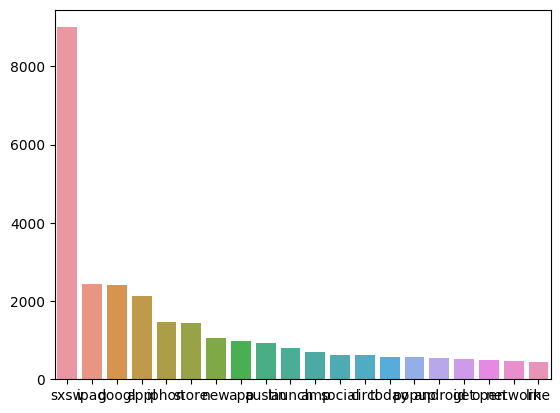

In [27]:
def freq_dist_plot(fdist):
  words = [tup[0] for tup in fdist]
  counts = [tup[1] for tup in fdist]
  sns.barplot(x=words, y=counts)

freq_dist_plot(_20)

Let's try to see if there's a difference depending on positive or negative tweets.

In [28]:
pos = df_practice[df_practice['emotion'] == 'Positive emotion']

#Make list of words
pos_words = [word for tweet in pos['text'] for word in tweet]

#Freq dist
pos_fdist = FreqDist(pos_words)

#Most common
pos_20 = pos_fdist.most_common(20)
pos_20

[('sxsw', 2953),
 ('ipad', 989),
 ('appl', 844),
 ('googl', 659),
 ('store', 529),
 ('iphon', 507),
 ('app', 458),
 ('new', 353),
 ('austin', 280),
 ('popup', 209),
 ('get', 202),
 ('launch', 188),
 ('android', 187),
 ('amp', 175),
 ('open', 175),
 ('go', 156),
 ('one', 143),
 ('parti', 141),
 ('time', 140),
 ('line', 139)]

In [29]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

finder = BigramCollocationFinder.from_words(pos_words)

scored = finder.score_ngrams(bigram_measures.raw_freq)

scored[:20]

[(('appl', 'store'), 0.007031095266389384),
 (('iphon', 'app'), 0.004951475539710834),
 (('sxsw', 'appl'), 0.004885455865848023),
 (('store', 'sxsw'), 0.0039941902687000725),
 (('popup', 'store'), 0.0038621509209744503),
 (('ipad', 'sxsw'), 0.0035650623885918),
 (('appl', 'open'), 0.003532052551660395),
 (('austin', 'sxsw'), 0.003499042714728989),
 (('sxsw', 'ipad'), 0.003433023040866178),
 (('sxsw', 'googl'), 0.0032679738562091504),
 (('social', 'network'), 0.002838845976100878),
 (('ipad', 'app'), 0.0025747672806496337),
 (('googl', 'map'), 0.002541757443718228),
 (('new', 'social'), 0.0025087476067868226),
 (('appl', 'popup'), 0.0023106885851983893),
 (('downtown', 'austin'), 0.0022776787482669835),
 (('store', 'downtown'), 0.002244668911335578),
 (('googl', 'launch'), 0.002178649237472767),
 (('temporari', 'store'), 0.002178649237472767),
 (('new', 'ipad'), 0.0020796197266785502)]

In [30]:
neg = df_practice[df_practice['emotion'] == 'Negative emotion']
#Make list of words
neg_words = [word for tweet in neg['text'] for word in tweet]

#Freq dist
neg_fdist = FreqDist(neg_words)

#Most common
neg_20 = neg_fdist.most_common(20)
neg_20

[('sxsw', 551),
 ('ipad', 184),
 ('iphon', 156),
 ('googl', 135),
 ('appl', 102),
 ('app', 85),
 ('store', 44),
 ('like', 43),
 ('new', 41),
 ('need', 35),
 ('circl', 34),
 ('get', 34),
 ('social', 29),
 ('design', 29),
 ('use', 29),
 ('peopl', 29),
 ('launch', 28),
 ('go', 26),
 ('austin', 24),
 ('think', 24)]

In [31]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

finder = BigramCollocationFinder.from_words(neg_words)

scored = finder.score_ngrams(bigram_measures.raw_freq)

scored[:20]

[(('sxsw', 'ipad'), 0.0038092083471348128),
 (('iphon', 'app'), 0.00364359059291156),
 (('sxsw', 'googl'), 0.00364359059291156),
 (('appl', 'store'), 0.0034779728386883074),
 (('sxsw', 'iphon'), 0.0033123550844650546),
 (('googl', 'circl'), 0.002484266313348791),
 (('ipad', 'design'), 0.002484266313348791),
 (('iphon', 'sxsw'), 0.002484266313348791),
 (('new', 'social'), 0.002484266313348791),
 (('design', 'headach'), 0.0023186485591255384),
 (('sxsw', 'appl'), 0.0023186485591255384),
 (('googl', 'launch'), 0.0021530308049022857),
 (('ipad', 'sxsw'), 0.0021530308049022857),
 (('fascist', 'compani'), 0.001987413050679033),
 (('major', 'new'), 0.001987413050679033),
 (('social', 'network'), 0.001987413050679033),
 (('sxsw', 'sxsw'), 0.001987413050679033),
 (('call', 'circl'), 0.00182179529645578),
 (('network', 'call'), 0.00182179529645578),
 (('news', 'app'), 0.00182179529645578)]

As we can see from above, most of the postive and negative tweets share the same words. Let's build a function to find unique words to positive and negative tweets.

In [36]:
def unique(corpus, sentiment):
  """
  Takes in corpus which is dataframe containing all tweets.
  Also takes sentiment to find unique words for that sentiment.
  """
  #Create lists of positive and negative words
  positive_tweets = corpus[corpus['emotion'] == 'Positive emotion']
  positive_words = [word for tweet in positive_tweets['text'] for word in tweet]

  negative_tweets = corpus[corpus['emotion'] == 'Negative emotion']
  negative_words = [word for tweet in negative_tweets['text'] for word in tweet]

  #Create list of unique words for given sentiment
  uniques = []

  if sentiment == 'positive':
    for word in positive_words:
      if word not in negative_words:
        uniques.append(word)
  elif sentiment == 'negative':
    for word in negative_words:
      if word not in positive_words:
        uniques.append(word)

  return uniques

unique_negatives = unique(df_practice, 'negative')




Let's look at most commmon negative words.

In [43]:
freq_unique_neg = FreqDist(unique_negatives)
freq_unique_neg.most_common(20)

[('fascist', 14),
 ('classiest', 9),
 ('autocorrect', 9),
 ('fade', 8),
 ('americaquot', 8),
 ('swisher', 8),
 ('novelti', 7),
 ('deleg', 7),
 ('kara', 7),
 ('fals', 4),
 ('worst', 4),
 ('mock', 4),
 ('annoy', 4),
 ('socialview', 4),
 ('comment', 4),
 ('notic', 3),
 ('now���and', 3),
 ('terribl', 3),
 ('batterykil', 3),
 ('brick', 3)]

Let's look at most commmon positive words.

In [41]:
unique_positives = unique(df_practice, 'positive')

freq_unique_pos = FreqDist(unique_positives)
freq_unique_pos.most_common(30)

[('fun', 49),
 ('begin', 47),
 ('music', 36),
 ('conferencesquot', 31),
 ('event', 28),
 ('other', 28),
 ('school', 27),
 ('congress', 27),
 ('hot', 26),
 ('hollergram', 23),
 ('gowalla', 21),
 ('art', 21),
 ('expert', 21),
 ('pick', 21),
 ('congrat', 20),
 ('choic', 20),
 ('band', 18),
 ('sweet', 18),
 ('core', 17),
 ('holler', 16),
 ('gram', 16),
 ('bought', 16),
 ('physic', 16),
 ('street', 16),
 ('award', 15),
 ('retail', 15),
 ('jealou', 15),
 ('purchas', 15),
 ('killer', 15),
 ('giveaway', 15)]